# Neural Network vs. Perceptron

In this task, we apply a 3-layer Neural Network on a synthetically generated data to compare its performance with Perceptron.

## Task-I: Loading train and test data, plotting the training data 

### Auxiliary functions

In [1]:
####################### GENERAL AUXILIARY FUNCTIONS #######################
## The following structure helps us to have functions with multiple outputs
### credit: https://stat.ethz.ch/pipermail/r-help/2004-June/053343.html
list <- structure(NA,class="result")
"[<-.result" <- function(x,...,value) {
  args <- as.list(match.call())
  args <- args[-c(1:2,length(args))]
  length(value) <- length(args)
  for(i in seq(along=args)) {
    a <- args[[i]]
    if(!missing(a)) eval.parent(substitute(a <- v,list(a=a,v=value[[i]])))
  }
  x
}

### Reading data function

In [2]:
# reading the data
read.data <- function(file.name, scaling=FALSE) {
  data <- read.csv(file=file.name,head=TRUE,sep=",")
  data <- data[complete.cases(data),] # removes rows with NA values
  D <- ncol(data)
  x = data[,-D]
  y = data[,D]
  if (isTRUE(scaling)) {
    x = scale(x)
    y = scale(y)
  }
  return (list('x' = x, 'y' = y))
}

### Loading train and test data

In [3]:
#loading the datasets
set.seed(1234)          

list[train_X,train_Y] <- read.data('Task2B_train.csv') #loading train data
train_Y[train_Y==0] <- -1         # convert 0 labels to -1 
list[test_X,test_Y] <- read.data('Task2B_test.csv') #loading test data
test_Y[test_Y==0] <- -1         # convert 0 labels to -1

### Plotting train data with classes marked with different colors

In [4]:
#loading required libraries
library(ggplot2)

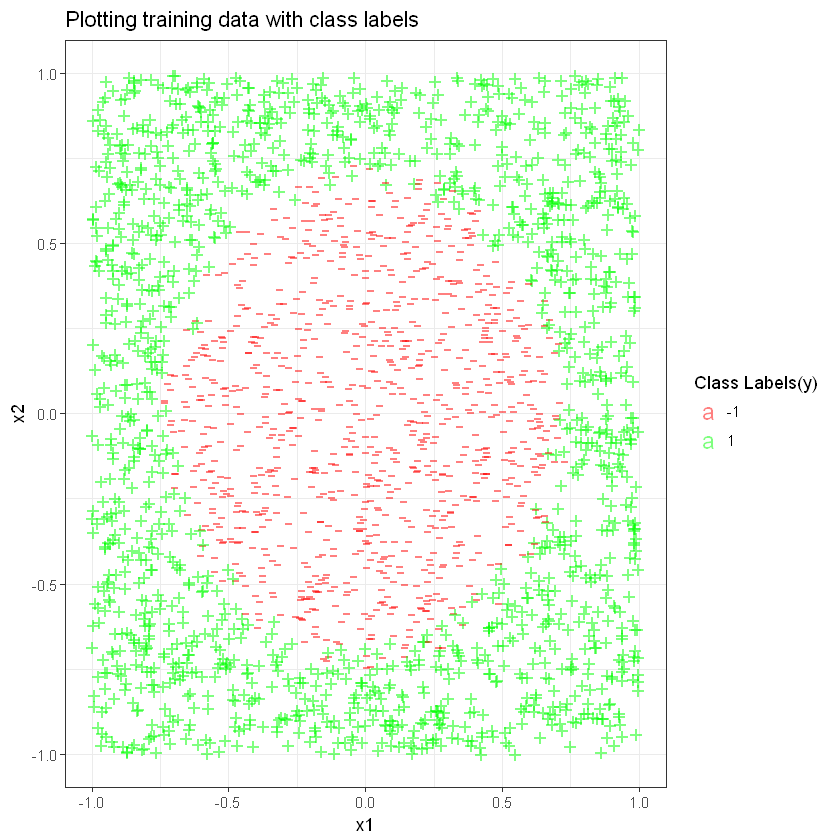

In [5]:
#plotting the training data
ggplot(data=cbind(train_X,train_Y), aes(x=x1, y=x2, color=factor(train_Y), label=ifelse(train_Y== 1, '+', '-'))) +
    geom_text(size = 5, alpha=0.5) + ggtitle("Plotting training data with class labels") + 
  scale_color_manual(name = "Class Labels(y)", values = c("red", "green")) + theme_bw()

## Task-II: Implementation of Perceptron

### Auxiliary functions

In [6]:
####################### Implementation of Perceptron Algorithm #######################
## prediction
perceptron.predict <- function(Phi, W){
  return(ifelse(Phi%*%W>=0, +1, -1))
}
## is it a misclassification? if yes, update the weight vector
is.a.miss <- function(Phi, W, T1){
  return((W%*%Phi)*T1<0)
}

In [7]:
## Perceptron Build function
perceptron.build <- function(X1, T1, eta=0.01, epsilon=0.001, tau.max=100, plotting=FALSE){
  if (length(unique(T1))!=2){
    stop("Perceptron: The input data is not a binary classification problem.")
  }
  if (all(sort(unique(T1)) != c(-1, 1))) {
    stop("Perceptron: The labels are not (-1, +1).")
  }
  
  N1 <- nrow(X1)
  Phi <- as.matrix(cbind(1, X1)) # add a column of 1 as phi_0

  W <- matrix(NA,nrow=tau.max, ncol=ncol(Phi)) # Empty Weight vector
  W[1,] <- 2*runif(ncol(Phi))-1 # Random initial values for weight vector
  error.rec <- matrix(NA,nrow=tau.max, ncol=1) # Placeholder for errors
  error.rec[1] <- error.rate(perceptron.predict(Phi, W[1,]), T1) # record error for initial weights
  tau <- 1 # iteration counter 
  terminate <- FALSE # termination status
  
  while(!terminate){
    # resuffling train data and associated labels:
    indx <- sample(1:N1, replace = FALSE)
    Phi <- Phi[indx,]
    T1 <- T1[indx]
    
    for (i in 1:N1){
      if (tau >= tau.max) {break}
      # look for missclassified samples
      if (is.a.miss(Phi[i,], W[tau,], T1[i])){
        tau <- tau +1                                 # update tau counter
        W[tau,] <- W[tau-1,] + eta * Phi[i,] * T1[i]  # update the weights
        error.rec[tau] <- error.rate(perceptron.predict(Phi, W[tau,]), T1)# update the records
        eta = eta * 0.99                                 # decrease eta
      } 
    }
    
    # recalculate termination conditions
    terminate <- tau >= tau.max | (abs(error.rec[tau] - error.rec[tau-1]) <= epsilon )
    
  }
  if (plotting){
    plot(error.rec[complete.cases(error.rec),], xlab = 'tau', ylab = 'error', main = 'Perceptron')
  }
  W <- W[complete.cases(W),]  # cut the empty part of the matrix (when the loop stops before tau == tau.max)
  return(W[nrow(W),])         # return the last wight vector
}

In [8]:
#creating an error function
error.rate <- function(Y1, T1){
  if (length(Y1)!=length(T1)){
    stop('error.rate: size of true lables and predicted labels mismatch')
  }
  return (sum(T1!=Y1)/length(T1))
}

### Training perceptron

[1] 0.009107961 0.084309368 0.064358194

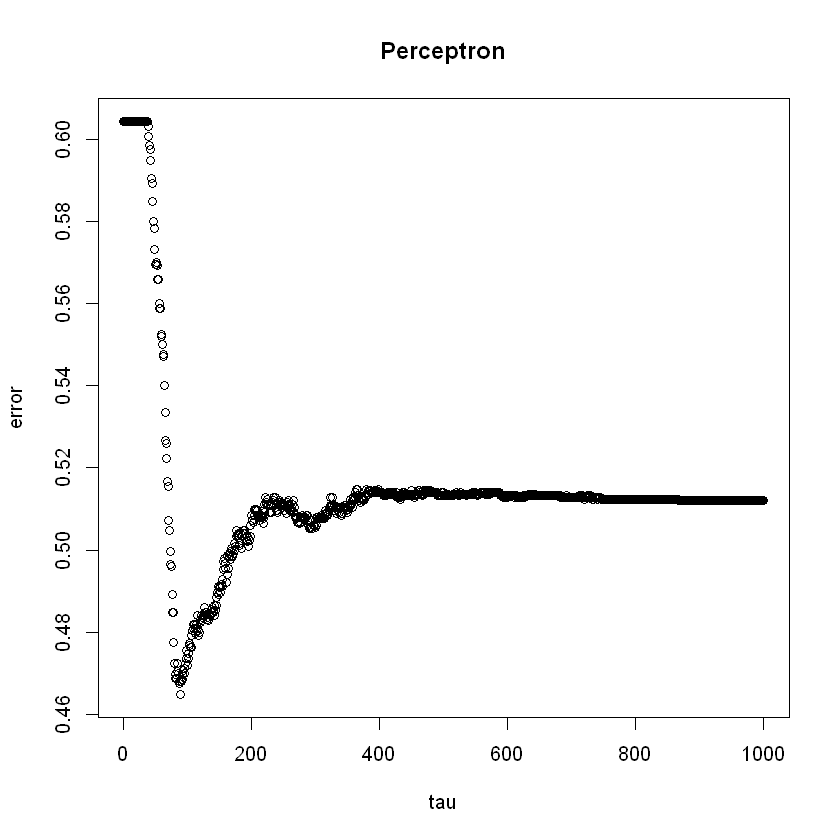

In [9]:
#training the perceptron using train data
trained_weights <- perceptron.build(train_X, train_Y, tau.max = 1000, plotting = TRUE)
trained_weights #displaying calculated weights

### Calculation of test error

In [10]:
#Calculation of test error
#save final weight vector for the perceptron
weights_final <- trained_weights
# Phi function of test data
Phi_test <- as.matrix(cbind(1, test_X)) # add a column of 1 as phi_0

# Predict the test labels based on the model from the above statements, and then compare the predicted labels
# with the real labels
test_predict <- perceptron.predict(Phi_test, weights_final) # get predicted labels
test_error <- error.rate(test_predict, test_Y) # compute test error
test_error #printing test error

[1] 0.514

### Plotting test data with actual and predicted class labels

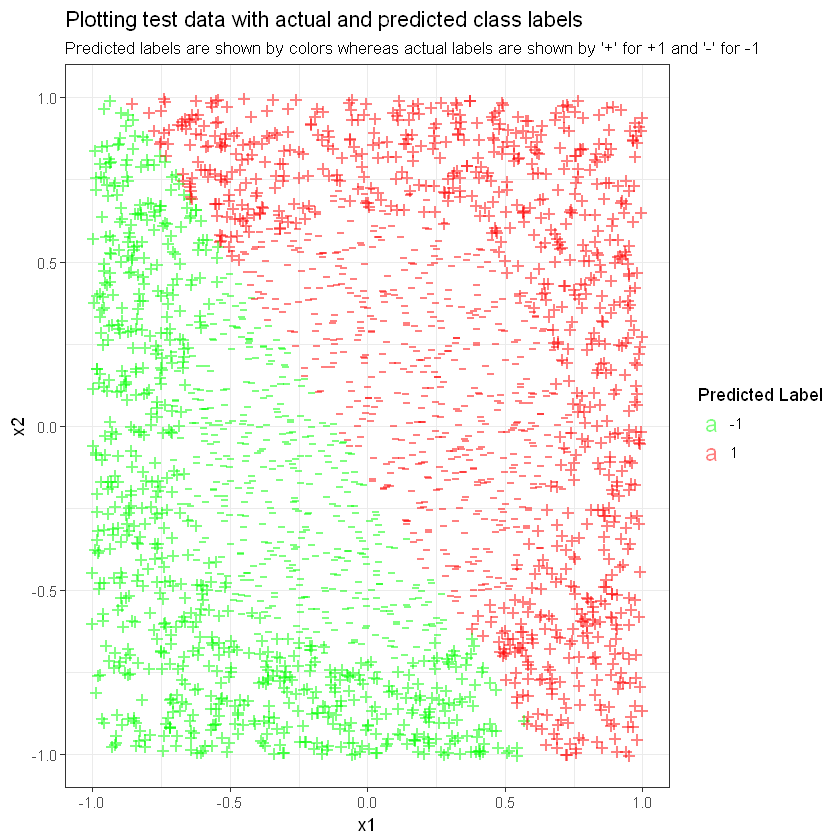

In [11]:
# Visualize the test data and results (with the actual labels shown as '+' and '-' and predicted labels are shown by colour)
ggplot(data=cbind(test_X,test_Y, test_predict), aes(x=x1, y=x2, color=factor(test_predict), label=ifelse(test_Y== 1, '+', '-'))) +
    geom_text(size = 5, alpha=0.5) + labs(title = "Perceptron: Plotting test data with actual and predicted class labels", color = "Predicted Label",
    subtitle = "Predicted labels are shown by colors whereas actual labels are shown by '+' for +1 and '-' for -1") + 
    scale_color_manual(values = c("green", "red")) + theme_bw()

## Task - III: Implementation of Neural Networks

In [12]:
####################### NEURAL NET ####################### 
## the activation function (tanh here)
h <- function(z, a=1) { #activation function (sigmoid here)
  return ((exp(z)-a^(-z))/(exp(z)+exp(-z)))
}
## the derivitive of the activation function (tanh here)
h.d <- function(z, a=1) {
  return (1-(h(z, a))^2)
}

## Class Probabilities
class.prob <- function(X, W1, W2, b1, b2){
  a2 <- h(sweep(W1 %*% X, 1, b1,'+' ))
  a3 <- h(sweep(W2 %*% a2, 1, b2,'+' ))
  return (a3)
}

## prediction
nn.predict <- function(X, W1, W2, b1, b2, threshold=0){
  return (ifelse(class.prob(X, W1, W2, b1, b2)>=threshold, 1, -1))
}

## feedforward step
feedforward <- function(Xi, Ti, W1, b1, W2, b2){
  ### 1st (input) layer 
  a1 <- Xi
  y <- Ti
  ### 2nd (hidden) layer
  z2 <- W1 %*% a1 + b1
  a2 <- h(z2)        
  ### 3rd (output) layer
  z3 <- W2 %*% a2 + b2
  a3 <- h(z3)  
  return(list(a1, a2, a3, y, z2, z3))
}

## backpropagation step
backpropagation <- function(Ti, W2, z2, z3, a3){
  ### 3rd (output) layer
  d3 <- -(Ti-a3) * h.d(z3)
  ### 2nd (hidden) layer
  d2 <-  t(W2)%*%d3  * h.d (z2)
  return(list(d2,d3))
}

## NN build function
nn.build <- function(K, X1, T1, plotting=FALSE, epoch.max=50, eta = 0.1, lambda = 0.01){
  # initialization
#   if (plotting) {error.rec <- matrix(NA,nrow=epoch.max, ncol=1)}
  D <- nrow(X1)
  if (D!=2) {stop('nn.predict: This simple version only accepts two dimensional data.')}
  N <- ncol(X1)

  W1 <- matrix(rnorm(D*K, sd=0.5), nrow=K, ncol=D)
  b1 <- matrix(rnorm(1*K), nrow=K, ncol=1)
  W2 <- matrix(rnorm(K*1, sd=0.5), nrow=1, ncol=K)
  b2 <- matrix(rnorm(1*1), nrow=1, ncol=1)

  for (epoch in 1:epoch.max){   
    ## delta vectors/matrices initialization
    W1.d <- W1 *0
    b1.d <- b1 *0
    W2.d <- W2 *0
    b2.d <- b2 *0

    for (i in 1:N){
      ## Feedforward:
      list[a1, a2, a3, y, z2, z3] <- feedforward(X1[,i], T1[i], W1, b1, W2, b2)          
      ## Backpropagation:
      list[d2, d3] <- backpropagation(T1[i], W2, z2, z3, a3)
      ## calculate the delta values
      ### 1st layer
      W1.d <- W1.d + d2 %*% t(a1)
      b1.d <- b1.d + d2
      ### 2nd layer
      W2.d <- W2.d + d3 %*% t(a2)
      b2.d <- b2.d + d3
    }
    ## update weight vectors and matrices
    W1 <- W1 - eta * (W1.d/N + lambda*W1)
    b1 <- b1 - eta * (b1.d/N)
    W2 <- W2 - eta * (W2.d/N + lambda*W2)
    b2 <- b2 - eta * (b2.d/N)
    ## record the errors
#     if (plotting){error.rec[epoch]<- error.rate(nn.predict(X1, W1, W2, b1, b2), T1)}
  }
#   plot(error.rec, xlab = 'epoch', ylab = 'error', main = 'Neural Net')
  return(list(W1, W2, b1, b2))
}

### Calculation of test errors for different number of hidden units

In [13]:
#transposing test and train data 
train_Xt <- t(as.matrix(train_X))
test_Xt <- t(as.matrix(test_X))

test_errors <- data.frame(matrix(nrow = 0, ncol = 2)) # empty dataframe to store test errors for different values of K
colnames(test_errors) <- c("K", "Test_error") # assigning names to the dataframe

# for every K
for (k in seq(2, 100, by= 2)) {
    # call the NN function
    list[W1, W2, b1, b2] <- nn.build(k, train_Xt, train_Y, plotting=FALSE, epoch.max=100, eta = 0.1, lambda = 0.01)
    test_errors[k/2,1] <- k # save the value of K in the errors data frame
    test_Y_pred <- nn.predict(test_Xt, W1, W2, b1, b2) # predict the labels by calling predict function
    test_errors[k/2,2] <- error.rate(t(as.matrix(test_Y_pred)),test_Y) # save the error value by calling error function
}
test_errors #displaying test errors

K,Test_error
2,0.3908
4,0.3908
6,0.3908
8,0.3908
10,0.3908
12,0.3908
14,0.3908
16,0.3908
18,0.3908
20,0.3908


### Plotting test error vs Number of hidden units (K)

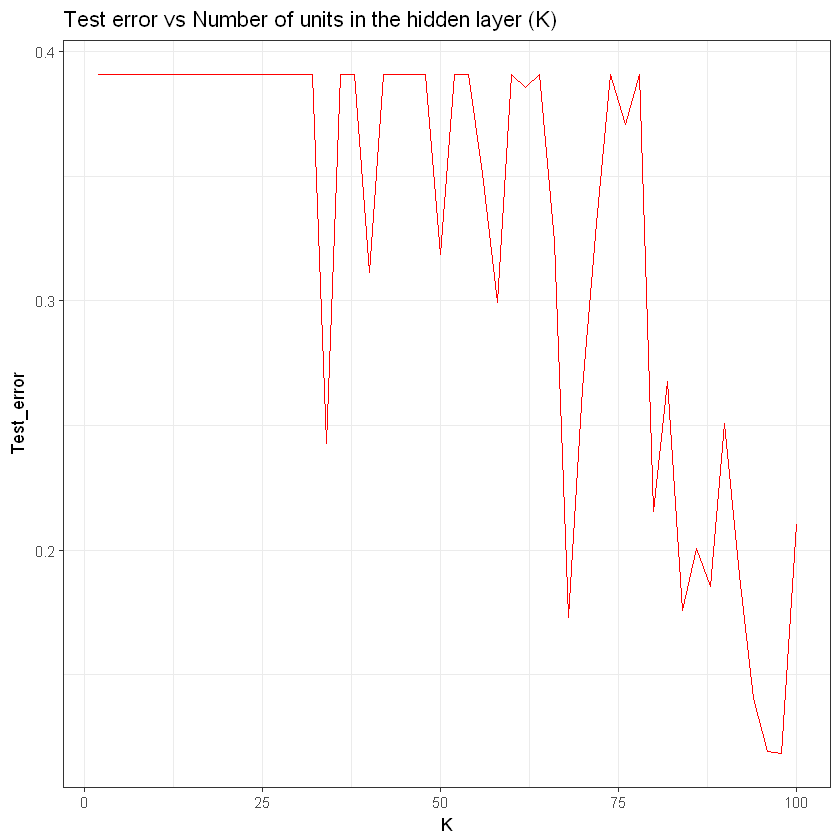

In [14]:
# plotting test errors vs number of hidden units (K)
ggplot(data=test_errors, aes(x=K, y=Test_error)) + ggtitle("Test error vs Number of units in the hidden layer (K)") +
    geom_line(color = "red") + theme_bw()

### Finding the minimum test error

In [15]:
# finding the minimum test error
min_error = min(test_errors[,2], na.rm = TRUE)
min_error #displaying the minimum error

[1] 0.1184

### Optimum(best) K

In [16]:
# finding the best K corresponding to the minimum error 
best_K = test_errors[test_errors[, 2] == min_error,1]
best_K

[1] 98

### Best K corresponding model prediction of labels

In [17]:
# call the NN function using best K and predict labels
list[W1, W2, b1, b2] <- nn.build(best_K, train_Xt, train_Y, plotting = FALSE, epoch.max = 100, eta = 0.1, lambda = 0.01)
test_Y_predict <- nn.predict(test_Xt, W1, W2, b1, b2)

### Plotting test data with actual and predicted labels marked with different colors 

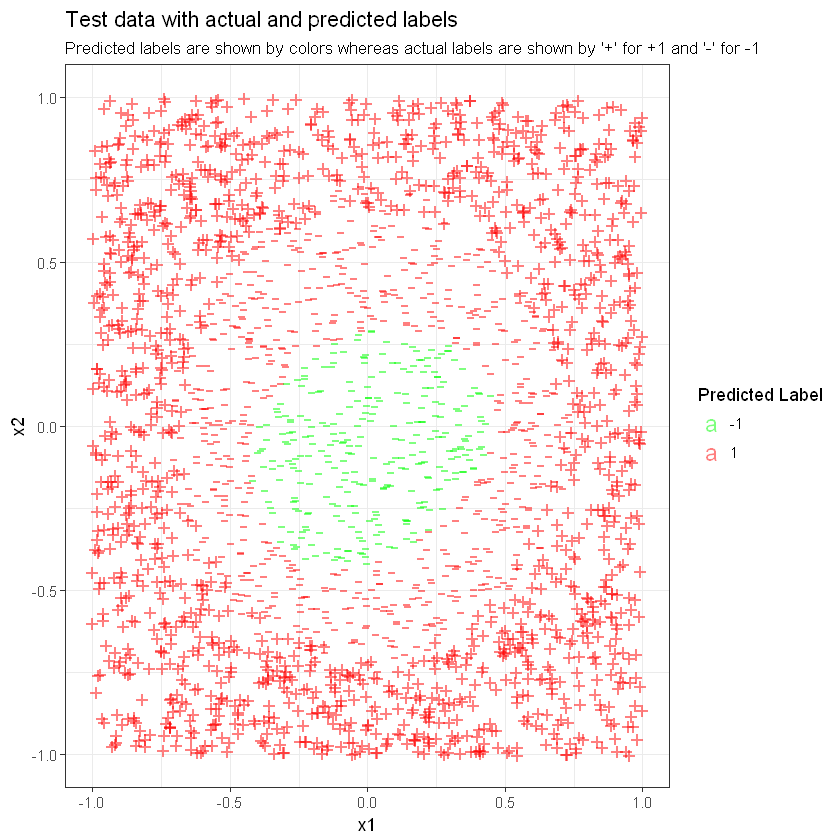

In [18]:
# plotting test data with actual and predicted labels
ggplot(data=cbind(test_X,test_Y, t(test_Y_predict)), aes(x=x1, y=x2, color=factor(test_Y_predict), label=ifelse(test_Y== 1, '+', '-'))) +
    geom_text(size = 5, alpha=0.5) + labs(title = "3-layer NN: Test data with actual and predicted labels", color = "Predicted Label",
    subtitle = "Predicted labels are shown by colors whereas actual labels are shown by '+' for +1 and '-' for -1") +
    scale_color_manual(values = c("green", "red")) + theme_bw()

## Task - IV: Reporting test errors of Percpetron and NN in a table

In [19]:
# combining error tables of perceptron and NN
table_errors <- rbind(test_errors, c('Perceptron_error', test_error))
table_errors # displaying the table of errors

K,Test_error
2,0.3908
4,0.3908
6,0.3908
8,0.3908
10,0.3908
12,0.3908
14,0.3908
16,0.3908
18,0.3908
20,0.3908


In [20]:
#finding the best model from the table
table_errors[table_errors[,2]==min(table_errors[,2]),]

,K,Test_error
49,98,0.1184


## Task - V: Explain the possible reasons for such difference between perceptron and 3-layer NN

The reasons are explained in the PDF report. Refer to the report